In [2]:
from typing import Tuple, List
import numpy as np
import pandas as pd
import json
import re
import random
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertForSequenceClassification, BertTokenizer
import matplotlib.pyplot as plt

# phonetics
import epitran  
import cologne_phonetics
from phonetisch import soundex
from abydos.phonetic import Phonet, Haase, RethSchek

c:\Users\milan\anaconda3\envs\small_machine_learning_projects_light\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. create sentences with common typos

In [ ]:
class StringManipulator:
    @staticmethod
    def manipulate_words(string: str, func, min_p: float = 0.1, max_p: float = 0.5) -> str:
        """
        manipulate each words with a probability between min_p and max_p
        """
        words = string.split(" ")
        # determine which words to manipulate
        p = random.uniform(min_p, max_p)
        pos_manipulate = [i for i in range(len(words)) if random.random() <= p]
        # manipulate
        string_final = ""
        for i, word in enumerate(words):
            if word != "":
                if i in pos_manipulate:
                    string_final += " " + random.choice(func(word))
                else:
                    string_final += " " + word
        return string_final[1:]
    
    @staticmethod
    def generate_capitalizations(s: str) -> List[str]:
        results = []
        max_num = 1 << len(s)  # 2^len(s)
        for i in range(max_num):
            word = []
            for j in range(len(s)):
                if i & (1 << j):
                    word.append(s[j].upper())
                else:
                    word.append(s[j].lower())
            results.append(''.join(word))
        return results

    def replace_group(self, string: str, group_members: List[str], adapt_capitalization: bool = "first"):
        # for adapting capitalization
        if adapt_capitalization != False:
            group_members_capitalized = []
            for m in group_members:
                group_members_capitalized.extend(self.generate_capitalizations(m))
        else:
            group_members_capitalized = group_members
        # to_repl -> repl_with
        variants = []
        for to_repl in group_members_capitalized:
            to_repl = re.sub(pattern="\.", repl="\.", string=to_repl)
            for repl_with in group_members:
                if repl_with != to_repl:
                    # adapt capitalization
                    if adapt_capitalization == "first":
                        if to_repl[0].isupper():
                            repl_with = list(repl_with)
                            repl_with[0] = repl_with[0].upper()
                            repl_with = "".join(repl_with)
                    elif adapt_capitalization == "auto":
                        if to_repl[0].isupper() and to_repl[1].isupper():
                            repl_with = repl_with.upper()
                        elif to_repl[0].isupper():
                            repl_with = list(repl_with)
                            repl_with[0] = repl_with[0].upper()
                            repl_with = "".join(repl_with)
                    # create variant
                    variant = re.sub(pattern=to_repl, repl=repl_with, string=string)
                    variants.append(variant)
        return variants


class Typo(StringManipulator):
    """
    uses german keyboard layout by default (only letters)
    """
    def __init__(self, alternative_layout: dict = None) -> None:
        super().__init__()
        self.epi = epitran.Epitran('deu-Latn')
        self.phonet = Phonet()
        self.haase = Haase()
        self.rethshek = RethSchek()
        if alternative_layout is not None:
            layout = alternative_layout
        else:
            layout = {
            'q': (0, 0), 'w': (0, 1), 'e': (0, 2), 'r': (0, 3), 't': (0, 4), 'z': (0, 5), 'u': (0, 6), 'i': (0, 7), 'o': (0, 8), 'p': (0, 9), 'ü': (0, 10),
            'a': (1, 0), 's': (1, 1), 'd': (1, 2), 'f': (1, 3), 'g': (1, 4), 'h': (1, 5), 'j': (1, 6), 'k': (1, 7), 'l': (1, 8), 'ö': (1, 9), 'ä': (1, 10),
            'y': (2, 0), 'x': (2, 1), 'c': (2, 2), 'v': (2, 3), 'b': (2, 4), 'n': (2, 5), 'm': (2, 6)}
        # euclidian distance
        coords = np.array(list(layout.values()))
        dist_matrix = np.sqrt(np.sum((coords[:, np.newaxis, :] - coords[np.newaxis, :, :]) ** 2, axis=-1))
        for i in range(len(dist_matrix)):
            dist_matrix[i][i] = np.inf  # main diagonal = inf to ignore replacing key with itself
        self.dist_df = pd.DataFrame(data=dist_matrix, columns=list(layout.keys()), index=list(layout.keys()))

    @staticmethod
    def lastvowels_positions(string: str) -> List[int]:
        return [v.end() -1 for v in re.finditer(pattern="[aeiouäöüAEIOUÄÖÜ]+", string=string)]
    
    def german_phonetic_similarity(self, str1: str, str2: str) -> str:
        epitran = self.epi.transliterate(str1) == self.epi.transliterate(str2)
        cologne = " ".join([p[1] for p in cologne_phonetics.encode(str1)]) == " ".join([p[1] for p in cologne_phonetics.encode(str2)])
        phonetisch = soundex.encode_word(str1) == soundex.encode_word(str2)
        haase = self.haase.encode(str1) == self.haase.encode(str2)
        rethschek = self.rethshek.encode(str1) == self.rethshek.encode(str2)
        phonet = self.phonet.encode(str1) == self.phonet.encode(str2)
        sum = int(epitran) + int(cologne) + int(phonetisch) + int(phonet) + int(haase) + int(rethschek)
        return sum > 3

    def all(self, string: str, balanced: bool = True) -> List[str]:
        d = self.deletion(string)
        t = self.transposition(string)
        i = self.insertion(string)
        ki = self.keyboard_substitution(string=string)
        p = self.phonetics(string)
        if balanced:
            k = max(min(len(d), len(t), len(i), len(ki), len(p)), 1)
            if len(d) != 0:
                d = random.choices(d, k=k)
            if len(t) != 0:
                t = random.choices(t, k=k)
            if len(i) != 0:
                i = random.choices(i, k=k)
            if len(ki) != 0:
                ki = random.choices(ki, k=k)
            if len(p) != 0:
                p = random.choices(p, k=k)
        return list(set(d + t + i + ki + p))

    def deletion(self, string: str) -> List[str]:
        variants = []
        for pos in range(len(string)):
            variants.append(string[:pos] + string[(pos + 1):])
        return list(set(variants))
    
    def transposition(self, string: str) -> List[str]:
        variants = []
        for pos in range(len(string) - 1):
            if (pos + 2) < len(string):
                variants.append(string[:pos] + string[pos + 1] + string[pos] + string[(pos + 2):])
            else:
                variants.append(string[:pos] + string[pos + 1] + string[pos])
        if string in variants:
            variants.remove(string)
        return variants
    
    def insertion(self, string: str) -> List[str]:
        variants = []
        for pos in range(len(string)):
            chars = self.keyboard_substitution(string=string[pos])
            chars.append(string[pos])
            for char in chars:
                variants.append(string[:pos] + char + string[pos:])
        return list(set(variants))

    def keyboard_substitution(self, string: str, max_dist: float = 1, char_positions: List[int] = None) -> List[str]:
        if char_positions is None:
            char_positions = range(len(string))
        variants = []
        for pos in char_positions:
            char = string[pos]
            if char in self.dist_df.index:
                repl_with = self.dist_df[char][self.dist_df[char] <= max_dist].index
                variants.extend([string[:pos] + c + string[(pos + 1):] for c in repl_with])
        return variants
    
    def phonetics(self, string: str) -> List[str]:
        def insert_h(string: str, match_nrs: int = None):
            if match_nrs is None:
                match_nrs = range(len(string))
            string_out = ""
            match_nr = -1
            pos_lasts = self.lastvowels_positions(string)
            for i in range(len(string)):
                string_out += string[i]
                if i in pos_lasts:
                    if i != 0:
                        if string[i] != string[i - 1]:
                            if len(string) >= (i + 3):
                                if (string[i + 1] != string[i + 2]) and (string[i+1:i+2] != "dt"):
                                    match_nr += 1
                                    if match_nr in match_nrs:
                                        string_out += "h"
                            else:
                                match_nr +=1
                                if match_nr in match_nrs:
                                    string_out += "h"
                    else:
                        match_nr += 1
                        if match_nr in match_nrs:
                            string_out += "h"
            return string_out
        
        variants = []
        # h after vowel
        for i in range(len(self.lastvowels_positions(string))):
            variants.append(insert_h(string=string, match_nrs=[i]))
        variants.extend(self.replace_group(string=string, group_members=["ß", "s", "ss"]))
        variants.extend(self.replace_group(string=string, group_members=["dt", "tt", "t", "d"]))
        variants.extend(self.replace_group(string=string, group_members=["ld", "ld"]))
        variants.extend(self.replace_group(string=string, group_members=["t", "th"]))
        variants.extend(self.replace_group(string=string, group_members=["ai", "ei", "ay", "ey"]))
        variants.extend(self.replace_group(string=string, group_members=["er", "a"]))
        variants.extend(self.replace_group(string=string, group_members=["x", "ks", "cks", "chs"]))
        variants.extend(self.replace_group(string=string, group_members=["k", "ck", "c", "q"]))
        variants.extend(self.replace_group(string=string, group_members=["gk", "k"]))
        variants.extend(self.replace_group(string=string, group_members=["b", "p"]))
        variants.extend(self.replace_group(string=string, group_members=["z", "ts"]))
        variants.extend(self.replace_group(string=string, group_members=["g", "j"]))
        variants.extend(self.replace_group(string=string, group_members=["ph", "f", "v", "pf"]))
        variants.extend(self.replace_group(string=string, group_members=["ie", "i"]))
        variants.extend(self.replace_group(string=string, group_members=["eu", "oi", "oy", "äu"]))
        variants.extend(self.replace_group(string=string, group_members=["ts", "ds", "tz"]))
        variants.extend(self.replace_group(string=string, group_members=["e", "ä"]))
        variants.extend(self.replace_group(string=string, group_members=["i", "j", "y"]))
        variants.extend(self.replace_group(string=string, group_members=["ü", "y"]))
        variants.extend(self.replace_group(string=string, group_members=["ig", "ich"]))
        variants.extend(self.replace_group(string=string, group_members=["qu", "kv", "kw"]))
        variants.extend(self.replace_group(string=string, group_members=["tsch", "dsch", "dj", "tj", "zsch", "tzsch"]))

        variants = list(set(variants))
        variants.remove(string)
        variants_clean = []
        for v in variants:
            if self.german_phonetic_similarity(v, string):
                variants_clean.append(v)
        return variants_clean


class OCR(StringManipulator):
    def __init__(self) -> None:
        super().__init__()

    @staticmethod
    def whitespace(string: str) -> List[str]:
        variants = []
        for i in range(1, len(string)):
            variants.append(string[:i] + " " + string[i:])
        return variants

    @staticmethod
    def fragment(string: str) -> List[str]:
        """especially for badly scanned docs, small fragments might be misinterpreted as chars"""
        variants = []
        for fragment in ".,'`´":
            for i in range(len(string)):
                variants.append(string[:i] + fragment + string[i:])
        return variants

    def look(self, string: str) -> List[str]:
        variants = []
        variants.extend(self.replace_group(string=string, group_members=["rn", "m"], adapt_capitalization=False))
        variants.extend(self.replace_group(string=string, group_members=["e", "c"], adapt_capitalization=False))
        variants.extend(self.replace_group(string=string, group_members=["O", "0", "o", "Ö", "ö"], adapt_capitalization=False))
        variants.extend(self.replace_group(string=string, group_members=["V", "U", "v", "u"], adapt_capitalization=False))
        variants.extend(self.replace_group(string=string, group_members=[".", ","], adapt_capitalization=False))
        variants.extend(self.replace_group(string=string, group_members=[":", ";"], adapt_capitalization=False))
        variants.extend(self.replace_group(string=string, group_members=["!", "I", "1", "l"], adapt_capitalization=False))
        variants.extend(self.replace_group(string=string, group_members=["n", "h"], adapt_capitalization=False))
        variants.extend(self.replace_group(string=string, group_members=["S", "s", "5"], adapt_capitalization=False))
        variants.extend(self.replace_group(string=string, group_members=["B", "8"], adapt_capitalization=False))
        variants.extend(self.replace_group(string=string, group_members=["vv", "w", "VV", "W"], adapt_capitalization=False))
        variants.extend(self.replace_group(string=string, group_members=["ij", "u"], adapt_capitalization=False))
        variants.extend(self.replace_group(string=string, group_members=["cl", "d"], adapt_capitalization=False))
        variants.extend(self.replace_group(string=string, group_members=["-", "_"], adapt_capitalization=False))
        variants.extend(self.replace_group(string=string, group_members=["'", "`", "´", "°"], adapt_capitalization=False))
        variants = list(set(variants))
        variants.remove(string) 
        return variants
    
    def all(self, string: str, balanced: bool = True, p_w: float = 0.15, p_f: float = 0.15) -> List[str]:
        p_l = 1 - (p_w + p_f)  # TODO implement probability based
        w = self.whitespace(string)
        f = self.fragment(string)
        l = self.look(string)
        if balanced:
            k = max(min(len(w), len(f), len(l)), 1)
            w = random.choices(w, k=k)
            f = random.choices(f, k=k)
            l = random.choices(l, k=k)
        return list(set(w + f + l))
    

def check_for_abbreviations(string: str):
    matches = re.finditer(pattern="\w+\.\s", string=string)
    match_strs = []
    for match in matches:
        match_strs.append(string[match.start(): match.end()])
    print(pd.Series(match_strs).value_counts().head(40))

In [8]:
# load data
with open("recipes.json", "rb") as f:
    j = json.load(f)
instructions = ". ".join(list(set([j[i]["Instructions"] for i in range(len(j))])))


# delete . from abbreviations to allow splitting per .
instructions = re.sub(pattern="ca\.", repl="ca", string=instructions)
instructions = re.sub(pattern="Min\.", repl="Min", string=instructions)
instructions = re.sub(pattern="min\.", repl="min", string=instructions)
instructions = re.sub(pattern="evtl\.", repl="evtl", string=instructions)
instructions = re.sub(pattern="bzw\.", repl="bzw", string=instructions)
instructions = re.sub(pattern="Ca\.", repl="ca", string=instructions)
instructions = re.sub(pattern="B\.", repl="B", string=instructions)
instructions = re.sub(pattern="[0-9]\.", repl="", string=instructions)
sentences = pd.Series([s.strip() for s in instructions.split(".")])

In [9]:
# used to generate faulty sentences
"""
typo = Typo()
versions = []
for i in range(36):
    print("version", i)
    sentences_typo = []
    for j, sentence in enumerate(sentences):
        sentences_typo.append(typo.manipulate_words(string=sentence, min_p=0.1, max_p=0.3, func=typo.all))
    pd.Series(sentences_typo).to_frame().to_csv(f"recipe_variants/{i}.csv", index=False)
"""

'\nfrom german_spelling import Typo\n\ntypo = Typo()\nversions = []\nfor i in range(36):\n    print("version", i)\n    sentences_typo = []\n    for j, sentence in enumerate(sentences):\n        sentences_typo.append(typo.manipulate_words(string=sentence, min_p=0.1, max_p=0.3, func=typo.all))\n    pd.Series(sentences_typo).to_frame().to_csv(f"recipe_variants/{i}.csv", index=False)\n'

# 2. train sequence classifier to detect sentences with typos

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, input_tensor: torch.Tensor, target_tensor: torch.Tensor):
        self.input_tensor = input_tensor
        self.target_tensor = target_tensor

    def __len__(self) -> int:
        return len(self.input_tensor)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.input_tensor[idx], self.target_tensor[idx]

In [10]:
batch_size = 64


# load original sentences and faulty sentences and split them into train and test sets
variants = []
for i in range(36):
    variants.append(pd.read_csv(f"recipe_variants/{i}.csv"))
variants = pd.concat(variants, axis=1)

variants.columns = [str(i) for i in range(36)]
variants.eq(sentences, axis=0).any(axis=1).mean()
for col in variants.columns:
    variants[col] = variants[col].where(variants[col] != sentences, "")

variants = variants[sentences != ""].dropna()
negatives_train = variants.head(30_000)
negatives_test = variants[~variants.index.isin(negatives_train.index)]
negatives_train = negatives_train.values.reshape(30_000 * 36)
negatives_train = negatives_train[negatives_train != ""]
negatives_test = negatives_test.values.reshape(13746 * 36)
negatives_test = negatives_test[negatives_test != ""]
positives_train = sentences.head(30_000)
positives_test = sentences[~sentences.index.isin(positives_train.index)]
negatives_train = pd.Series(negatives_train).sample(frac=1).values[:len(positives_train)]
negatives_test = pd.Series(negatives_train).sample(frac=1).values[:len(positives_test)]

# tokenize sentences to form input ids (usually it is recommended to use masking)
tok = BertTokenizer.from_pretrained("bert-base-german-cased")
negatives_train_tokens = torch.tensor(tok(list(negatives_train), truncation=True, max_length=64, padding="max_length")["input_ids"])
positives_train_tokens = torch.tensor(tok(list(positives_train), truncation=True, max_length=64, padding="max_length")["input_ids"])

negatives_test_tokens = torch.tensor(tok(list(negatives_test), truncation=True, max_length=64, padding="max_length")["input_ids"])
positives_test_tokens = torch.tensor(tok(list(positives_test), truncation=True, max_length=64, padding="max_length")["input_ids"])

inputs_train = torch.cat([negatives_train_tokens, positives_train_tokens])
inputs_test = torch.cat([negatives_test_tokens, positives_test_tokens])

# create target tensors
train_target = torch.ones(len(negatives_train_tokens) + len(positives_train_tokens), dtype=int)
train_target[:len(negatives_train_tokens)] = 0
test_target = torch.ones(len(negatives_test_tokens) + len(positives_test_tokens), dtype=int)
test_target[:len(negatives_test_tokens)] = 0


# create dataloader
dataset_train = CustomDataset(inputs_train, train_target)
dataset_test = CustomDataset(inputs_test[:1024], test_target[:1024])
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)


In [20]:
# train eval loop
model = BertForSequenceClassification.from_pretrained("bert-base-german-cased")
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

accs_train_outer = []
accs_test_outer = []
for e in range(200):
    model.train()
    accs_train = []
    for i, batch in enumerate(dataloader_train):
        x, y = batch
        out = model(input_ids=x, labels=y)
        loss = out["loss"]
        # train acc is here not calculated properly for simplification
        accs_train.append(((torch.argmax(out["logits"], dim=1) == y).sum() / batch_size).item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if i == 20:
            break
    print("train:", torch.tensor(accs_train).mean().item())
    accs_train_outer.append(torch.tensor(accs_train).mean().item())
    model.eval()
    accs_test = []
    with torch.no_grad():
        for i, batch in enumerate(dataloader_test):
            x, y = batch
            out = model(input_ids=x, labels=y)
            accs_test.append(((torch.argmax(out["logits"], dim=1) == y).sum() / batch_size).item())
    print("test:", torch.tensor(accs_test).mean().item())
    accs_test_outer.append(torch.tensor(accs_test).mean().item())
    torch.save(model, f"model{e}.pt")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


train: 0.590029776096344
test: 0.77734375
train: 0.8221726417541504
test: 0.70703125
train: 0.8288690447807312
test: 0.748046875
train: 0.8563988208770752
test: 0.7734375
train: 0.8526785969734192
test: 0.7783203125
train: 0.8623511791229248
test: 0.79296875
train: 0.8549107313156128
test: 0.7265625
train: 0.8571428656578064
test: 0.736328125
train: 0.8333333134651184
test: 0.7529296875
train: 0.883184552192688
test: 0.7578125
train: 0.8459821343421936
test: 0.8076171875
train: 0.8422619104385376
test: 0.7041015625
train: 0.8623511791229248
test: 0.765625
train: 0.882440447807312
test: 0.7578125
train: 0.8616071343421936
test: 0.8212890625
train: 0.8534226417541504
test: 0.7060546875
train: 0.866815447807312
test: 0.7744140625
train: 0.8623511791229248
test: 0.763671875
train: 0.8623511791229248
test: 0.7353515625
train: 0.875
test: 0.783203125
train: 0.8563988208770752
test: 0.7646484375
train: 0.8809523582458496
test: 0.7919921875
train: 0.8482142686843872
test: 0.7939453125
train: 0

# 3. use gradcam to deduct instance level prediction from bag level prediction 
- bag level: sentence contains typo y/n
- instance level: word contains typo y/n

In [3]:
def mask(tensor: torch.Tensor, thresh: float) -> torch.Tensor:
    return tensor > thresh

def greater_zero_or_none(tensor: torch.Tensor) -> torch.Tensor:
    if tensor is not None:
        return mask(tensor=tensor, thresh=0).int() * tensor
    
def rectify_hook(
        module: torch.nn.Module,
        grad_inputs: torch.Tensor,
        grad_outputs: torch.Tensor):
    new_grad_inputs = tuple([greater_zero_or_none(gi) for gi in grad_inputs])
    return new_grad_inputs


def display(text: str):
    # load model and tokenizer and prepare for calculating gradcam on embeddings
    model: BertForSequenceClassification = torch.load("model199.pt")
    for module in model.modules():
        module.register_backward_hook(rectify_hook)
    tok = BertTokenizer.from_pretrained("bert-base-german-cased")
    model.eval()
    input_ids = torch.tensor(tok(text)["input_ids"]).unsqueeze(0)
    e: torch.Tensor = model.bert.embeddings(input_ids)
    e.requires_grad_(True)
    e.retain_grad()

    # calculate gradcam
    logits = model.forward(inputs_embeds=e)["logits"]
    pred = np.round(torch.nn.functional.softmax(logits)[0][0].item(), 2)
    logit = logits[0][0]
    logit.backward()
    grad = torch.mean(e.grad.data, dim=2).squeeze()
    grad = grad[1:-1]
    grad = grad + grad.min() * -1
    grad = grad / grad.sum()

    # merge tokens into words and sum up gradcam per word
    tokens = tok.tokenize(text)
    tokens_clean = [tokens[i] if tokens[i+1][:2] == "##" else tokens[i] + " " for i in range(len(tokens) - 1)]
    tokens_clean.append(tokens[-1])
    tokens_clean = [t[2:] if t[:2] == "##" else t for t in tokens_clean]
    word_grads = []
    words = []
    grad_val = 0
    word = ""
    for i in range(len(tokens_clean)):
        if tokens_clean[i][-1] == " ":
            word += tokens_clean[i]
            grad_val += grad[i]
            word_grads.append(grad_val)
            words.append(word)
            word = ""
            grad_val = 0
        else:
            word += tokens_clean[i]
            grad_val += grad[i]
            if i == (len(tokens_clean) - 1):
                words.append(word)
                word_grads.append(grad_val)
    words = [w[:-1] if w[-1] == " " else w for w in words]
    word_grads = [g.item() for g in word_grads]
    word_grads = np.array(word_grads).reshape(1, -1)

    # plot results
    fig, ax = plt.subplots(figsize=(10, 1))
    heatmap = ax.imshow(word_grads.reshape(1, -1), cmap='Reds', aspect='auto')

    # Adding labels within each cell
    for i, label in enumerate(words):
        ax.text(i, 0, label, ha='center', va='center', color='black')

    ax.set_title(f"word-level gradcam\nprediction: sentence contains typo (confidence: {str(pred)})")
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()
    plt.savefig(f"gradcam.png")

c:\Users\milan\anaconda3\envs\small_machine_learning_projects_light\lib\site-packages\torch\nn\modules\module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
c:\Users\milan\anaconda3\envs\small_machine_learning_projects_light\lib\site-packages\torch\nn\modules\module.py:1319: UserWarning: Using non-full backward hooks on a Module that does not take as input a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using non-full backward hooks on a Module that does not take as input a "
c:\Users\mila

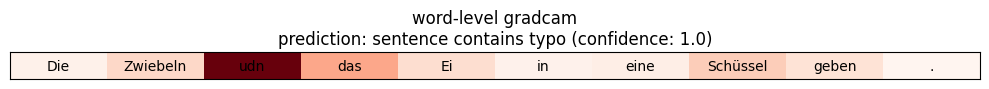

In [4]:
display("Die Zwiebeln udn das Ei in eine Schüssel geben.")